In [21]:
# pip install ultralytics
import cv2            # For webcam access and image processing
from ultralytics import YOLO  # For YOLOv5 object detection
import torch                  # PyTorch backend for YOLO
import numpy as np    # For array manipulation
import matplotlib.pyplot as plt # For displaying images in notebook
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.7.1+cpu
CUDA available: False


Captured a frame successfully!


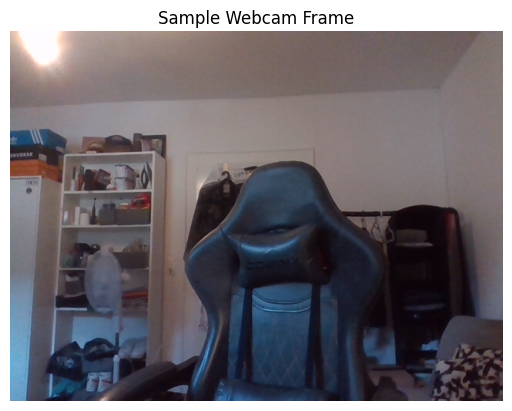

In [5]:
# Initialize the default camera (index 0)
cap = cv2.VideoCapture(0)

# Check if webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not access webcam.")
else:
    ret, frame = cap.read()
    if ret:
        print("Captured a frame successfully!")
        # Convert the image from BGR to RGB for matplotlib display
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_frame)
        plt.axis('off')
        plt.title("Sample Webcam Frame")
    else:
        print("Error: Could not read frame from webcam.")

# Release the webcam for now
cap.release()


PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


0: 480x640 1 person, 1 backpack, 2 chairs, 188.9ms
Speed: 4.4ms preprocess, 188.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
Detected objects: ['person', 'chair', 'backpack', 'chair']


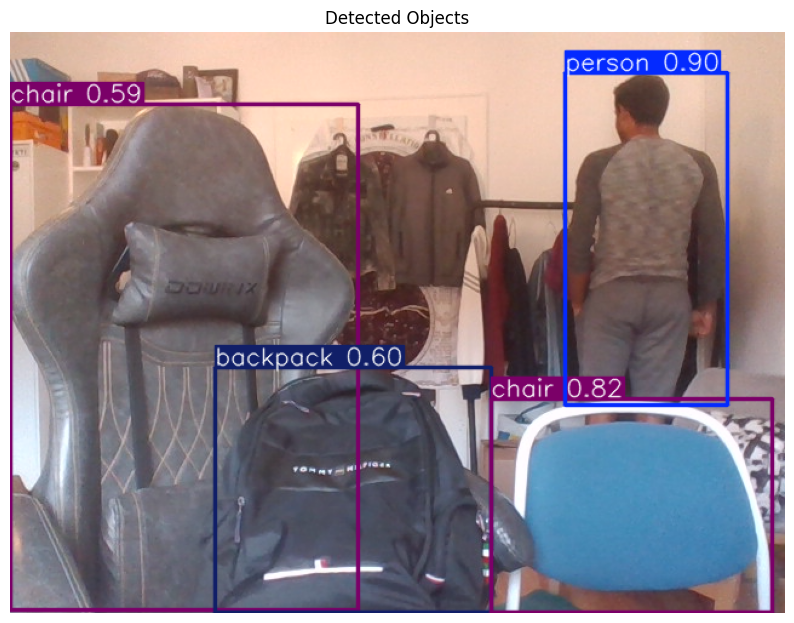

In [ ]:


# Load YOLOv5 model (this will download automatically on first use)
model = YOLO('yolov5s.pt')  # YOLOv5 small model

# Capture a frame for detection
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

if ret:
    # Object detection using YOLOv5
    results = model(frame)
    
    # Extract labels
    labels = []
    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0])
            label = model.names[class_id]
            labels.append(label)
    
    print("Detected objects:", labels)
    
    # Draw bounding boxes and show result
    annotated_frame = results[0].plot()
    rgb_output = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(rgb_output)
    plt.axis('off')
    plt.title("Detected Objects")
    plt.show()
else:
    print("Webcam frame not captured.")


In [19]:
def decide_action(labels):
    """Given a list of detected labels, decide the next robot action."""
    # List of obstacle classes (YOLO COCO dataset class names)
    obstacle_keywords = [
        'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
        'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
        'clock', 'scissors', 'teddy bear', 'hair drier', 'toothbrush',
        'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'bottle',
        'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'vase',
        'bicycle', 'car', 'motorcycle', 'bus', 'truck', 'boat'
    ]
    
    # Check for person
    if 'person' in labels:
        print("🛑 STOP: Person detected! (🔴 Laser Activated on Target)")
        return "STOP"
    
    # Check for obstacles
    detected_obstacles = [item for item in labels if item in obstacle_keywords]
    if detected_obstacles:
        print(f"🔄 REROUTE: Obstacles detected: {detected_obstacles}")
        return "REROUTE"
    
    # Path is clear
    print("✅ FORWARD: Path is clear. Moving ahead!")
    return "FORWARD"

# Test the updated function with YOLO class names
print("Testing decision logic with YOLOv5 classes:")
decide_action(['person', 'chair'])
decide_action(['bottle', 'cup'])
decide_action(['dog', 'cat'])  # Animals are not obstacles


Testing decision logic with YOLOv5 classes:
🛑 STOP: Person detected! (🔴 Laser Activated on Target)
🔄 REROUTE: Obstacles detected: ['bottle', 'cup']
✅ FORWARD: Path is clear. Moving ahead!


'FORWARD'

In [25]:
def real_time_object_detection():
    """Real-time object detection using YOLOv5"""
    # Load YOLOv5 model
    model = YOLO('yolov5s.pt')
    
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot open camera")
        return
    
    print("Starting real-time detection with YOLOv5. Press 'q' to quit.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break

        # YOLOv5 object detection
        results = model(frame, verbose=False)  # verbose=False reduces console output
        
        # Extract detected class labels
        labels = []
        for result in results:
            if result.boxes is not None:  # Check if any objects were detected
                for box in result.boxes:
                    class_id = int(box.cls[0])
                    label = model.names[class_id]
                    confidence = float(box.conf[0])
                    if confidence > 0.5:  # Only consider high-confidence detections
                        labels.append(label)
        
        # Apply decision-making logic
        action = decide_action(labels) if labels else decide_action([])

        # Draw bounding boxes using YOLOv5's built-in function
        annotated_frame = results[0].plot()
        
        # Add decision overlay text
        cv2.putText(annotated_frame, f"Action: {action}", (10, 40), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3, cv2.LINE_AA)
        
        # Show detected objects info
        cv2.putText(annotated_frame, f"Objects: {len(labels)}", (10, 80), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2, cv2.LINE_AA)
        
        # Display detected labels on screen
        if labels:
            unique_labels = list(set(labels))  # Remove duplicates
            labels_text = ", ".join(unique_labels[:3])  # Show max 3 labels
            cv2.putText(annotated_frame, f"Detected: {labels_text}", (10, 120), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

        # Display the result
        cv2.imshow('ReconBot Camera Feed - YOLOv5', annotated_frame)

        # Press 'q' to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Exiting real-time detection.")
            break
    
    cap.release()
    cv2.destroyAllWindows()

# (works better in terminal/script mode)
real_time_object_detection()


PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Starting real-time detection with YOLOv5. Press 'q' to quit.
✅ FORWARD: Path is clear. Moving ahead!
✅ FORWARD: Path is clear. Moving ahead!
✅ FORWARD: Path is clear. Moving ahead!
🔄 REROUTE: Obstacles detected: ['chair']
✅ FORWARD: Path is clear. Moving ahead!
✅ FORWARD: Path is clear. Moving ahead!
✅ FORWARD: Path is clear. Moving ahead!
✅ FORWARD: Path is clear. Moving ahead!
🛑 STOP: Person detected! (🔴 Laser Activated on Target)
🛑 STOP: Person detected! (🔴 Laser Activated on Target)
🛑 STOP: Person detected! (🔴 Laser Activated on Target)
🛑 STOP: Person detected! (🔴 Laser Activated on Target)
🛑 STOP: Person detected! (🔴 Laser Activated on Target)
🛑 STOP: Person detected! (🔴 Laser Activated on Target)
🛑 STOP: Person detected! (🔴 Lase